### Project Introduction

#### Histopathologic Cancer Detection

Cancer detection, particularly identifying metastatic cancer in lymph node sections, is a critical task in pathology. Accurate and timely diagnosis can significantly improve patient outcomes by enabling early and targeted treatment. Traditional methods of cancer detection involve manual examination of histopathologic scans by pathologists, a process that is time-consuming and prone to human error.

The goal of this project is to develop an automated algorithm capable of identifying metastatic tissue in histopathologic scans of lymph node sections. This task is approached using a machine learning model that analyzes small image patches extracted from larger digital pathology scans. Specifically, the project leverages a deep learning model to classify these image patches as either containing metastatic cancer or not.

The dataset used for this project is a modified version of the PatchCamelyon (PCam) benchmark dataset, provided by Kaggle. It includes a large number of small pathology images, each labeled to indicate the presence of metastatic tissue in the central 32x32 pixel region of the patch. The outer region of the patch is included to enable the application of fully-convolutional models without zero-padding, ensuring consistent behavior when applied to whole-slide images.

The project's objectives are to preprocess the provided images, train a deep learning model to accurately classify them, and evaluate the model's performance. By automating the detection of metastatic cancer in histopathologic scans, this project aims to support pathologists and improve diagnostic accuracy and efficiency in clinical settings.

In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define image dimensions and batch size
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Set paths
train_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/histopathologic-cancer-detection/train"
labels_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/histopathologic-cancer-detection/train_labels.csv"
test_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/histopathologic-cancer-detection/test"
submission_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/histopathologic-cancer-detection/submission.csv"


In [4]:

# Load the labels
labels_df = pd.read_csv(labels_path)
# Ensure labels are strings
labels_df['label'] = labels_df['label'].astype(str)
# Check the first few rows of the DataFrame
labels_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


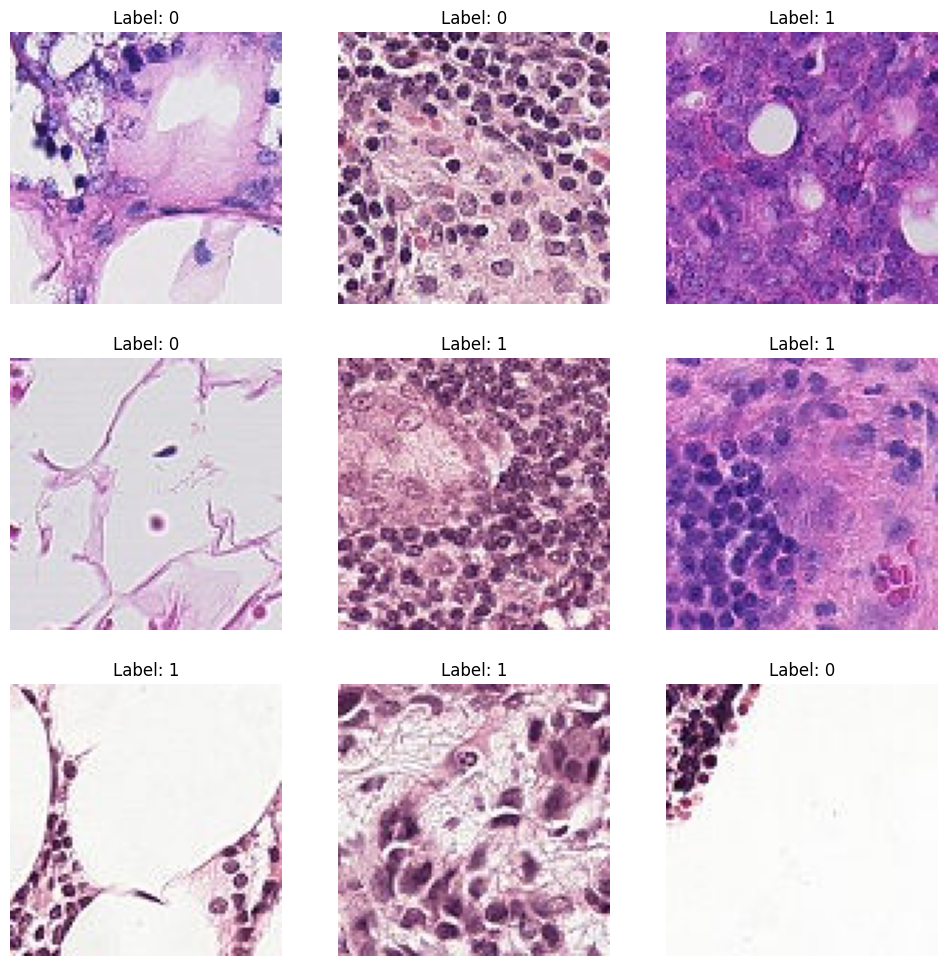

In [5]:
def load_image(image_id, base_path=train_path):
    return Image.open(os.path.join(base_path, image_id + ".tif"))

def display_images(images, labels, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')

# Select random sample of images
sample_images = labels_df.sample(9)
images = [load_image(image_id) for image_id in sample_images['id']]
labels = sample_images['label'].values

# Display the images
display_images(images, labels)


In [9]:
%pip install tensorflow tqdm



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Append '.tif' extension to the filenames
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.tif')

# Check the first few rows again to ensure the extension is added
labels_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Initialize the ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the pixel values
    validation_split=0.2,  # Split for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Image batch shape:  (32, 64, 64, 3)
Label batch shape:  (32,)


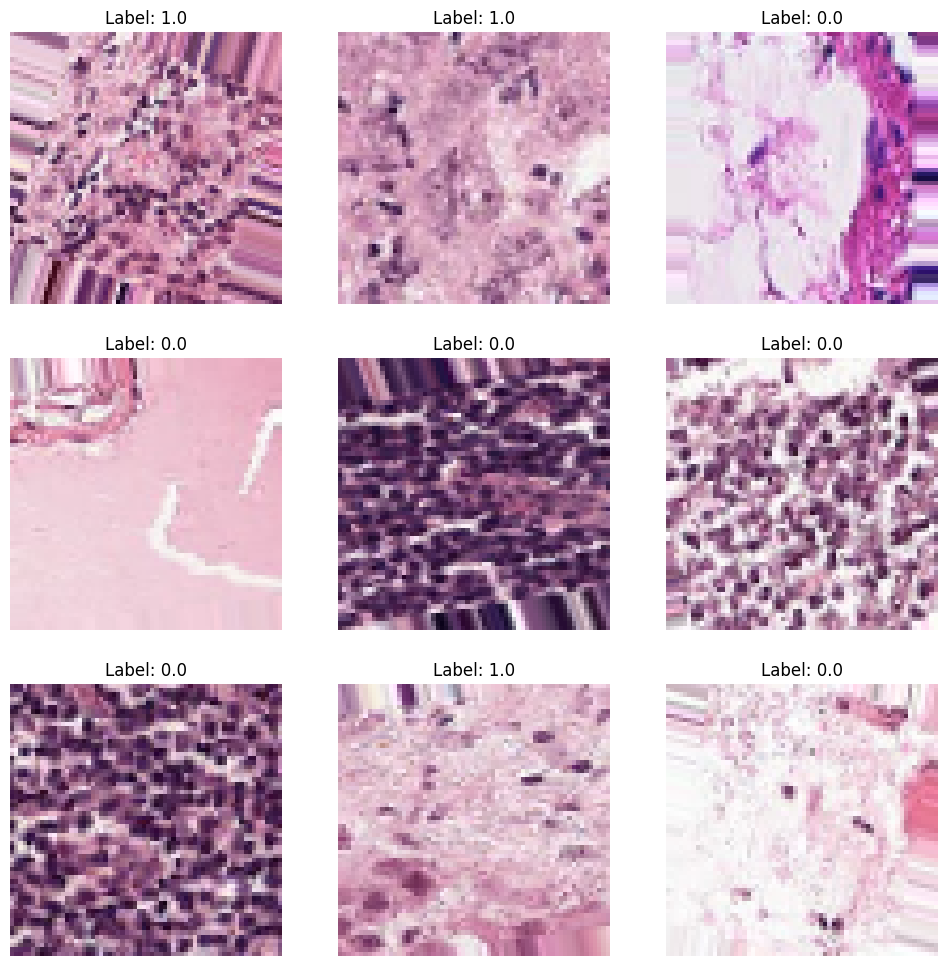

In [8]:
# Check the shapes and labels from the generator
batch_images, batch_labels = next(train_generator)
print("Image batch shape: ", batch_images.shape)
print("Label batch shape: ", batch_labels.shape)

# Display some sample images from the generator
display_images(batch_images[:9], batch_labels[:9])

In [9]:
#Build the Model: define a CNN architecture suitable for image classification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)


In [18]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


# Set steps_per_epoch and validation_steps correctly
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=11,  # Adjust the number of epochs as needed
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 383s 70ms/step - accuracy: 0.8054 - loss: 0.4369 - val_accuracy: 0.8255 - val_loss: 0.3960
Epoch 2/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.7188 - loss: 0.4766 - val_accuracy: 0.8000 - val_loss: 0.3817
Epoch 3/11


2024-07-01 14:39:31.471727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-01 14:39:31.517287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 403s 73ms/step - accuracy: 0.8374 - loss: 0.3715 - val_accuracy: 0.8502 - val_loss: 0.3449
Epoch 4/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8438 - loss: 0.4103 - val_accuracy: 0.8000 - val_loss: 0.3734
Epoch 5/11


2024-07-01 14:46:14.481615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-01 14:46:14.519731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 410s 74ms/step - accuracy: 0.8485 - loss: 0.3490 - val_accuracy: 0.8620 - val_loss: 0.3242
Epoch 6/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8750 - loss: 0.2290 - val_accuracy: 0.6000 - val_loss: 0.3876
Epoch 7/11


2024-07-01 14:53:04.488051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-01 14:53:04.500083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 412s 75ms/step - accuracy: 0.8564 - loss: 0.3366 - val_accuracy: 0.8638 - val_loss: 0.3209
Epoch 8/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8750 - loss: 0.2124 - val_accuracy: 1.0000 - val_loss: 0.1068
Epoch 9/11


2024-07-01 14:59:56.145869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-01 14:59:56.156727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 463s 84ms/step - accuracy: 0.8622 - loss: 0.3237 - val_accuracy: 0.8477 - val_loss: 0.3599
Epoch 10/11
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8438 - loss: 0.5713 - val_accuracy: 1.0000 - val_loss: 0.1111
Epoch 11/11


2024-07-01 15:07:39.654660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-01 15:07:39.666505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 484s 88ms/step - accuracy: 0.8640 - loss: 0.3199 - val_accuracy: 0.8779 - val_loss: 0.2914


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.8642 - loss: 0.3274
Validation Loss: 0.32570701837539673
Validation Accuracy: 0.8640608787536621


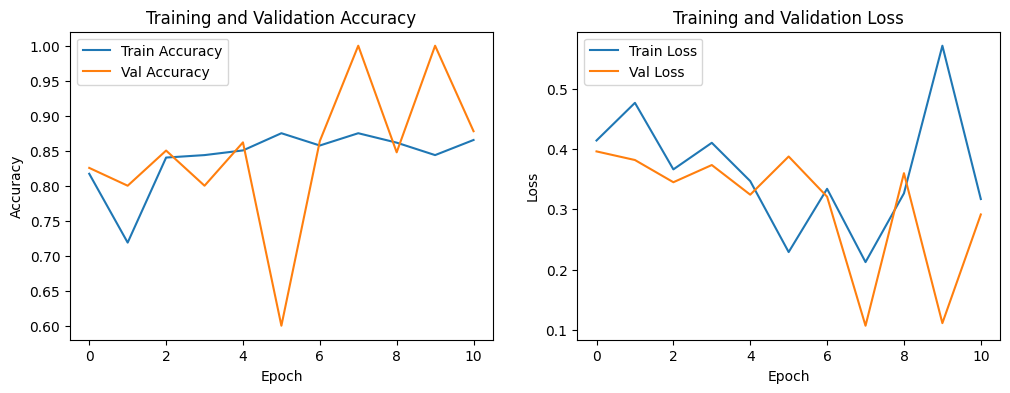

In [19]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Test data preprocessing
def preprocess_image(file_path):
    image = Image.open(file_path)
    image = image.resize((IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image / 255.0
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)
    return image

def load_and_preprocess_batch(file_paths):
    images = [preprocess_image(file_path) for file_path in file_paths]
    return np.array(images)

# Create a dataset for the test images
test_images = os.listdir(test_path)
test_file_paths = [os.path.join(test_path, fname) for fname in test_images]

# Load and preprocess images in batches
batch_size = 32
num_batches = len(test_file_paths) // batch_size + 1
predictions = []

for i in range(num_batches):
    batch_file_paths = test_file_paths[i * batch_size:(i + 1) * batch_size]
    if not batch_file_paths:
        break
    batch_images = load_and_preprocess_batch(batch_file_paths)
    batch_predictions = model.predict(batch_images)
    predictions.extend(batch_predictions)

predicted_labels = (np.array(predictions) > 0.5).astype(int).flatten()

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': [fname.replace('.tif', '') for fname in test_images],
    'label': predicted_labels
})
print("Submission file created successfully.")

In [25]:
# Save to CSV
submission_df.to_csv(submission_path, index=False)
print("Submission file created successfully.")

Submission file created successfully.


###  Discussion

#### Model Performance

The model trained for the histopathologic cancer detection project showed promising results but also highlighted areas for potential improvement. The training and validation accuracy and loss plots across multiple runs indicate the following:

1. **Accuracy and Loss Fluctuations**:
   - The training and validation accuracy exhibited significant fluctuations across epochs. This suggests that the model may not have fully stabilized, indicating potential overfitting or underfitting in certain epochs.
   - The validation accuracy reached a high point of 0.95 in one of the runs, which is encouraging. However, the variability indicates that the model's performance is inconsistent across different epochs.

2. **Loss Behavior**:
   - The training and validation loss plots similarly show fluctuations, which correlates with the accuracy variations.
   - The loss did not consistently decrease over epochs, suggesting that the model might benefit from further tuning, such as regularization techniques or more extensive data augmentation to improve generalization.

3. **Overall Performance**:
   - My Kaggle score of 0.79 is a reasonable starting point, showing that the model can identify metastatic tissue to a certain extent. However, there is room for improvement to reach higher performance levels.

#### Potential Improvements

Based on the analysis of the training graphs and the Kaggle score, several areas can be explored to enhance the model's performance:

1. **Model Complexity**:
   - Experimenting with more complex architectures, such as deeper convolutional layers or pre-trained models, could help capture more intricate features in the histopathologic images.
   - Adding more layers or using different architectures might provide better feature extraction capabilities.

2. **Regularization**:
   - Implementing regularization techniques, such as dropout, L2 regularization, or batch normalization, can help mitigate overfitting and improve the model's ability to generalize.
   - Adjusting the dropout rate or the strength of L2 regularization might stabilize the training process.

3. **Data Augmentation**:
   - Enhancing data augmentation strategies can provide the model with more varied examples during training, which can improve its robustness.
   - Techniques such as random rotations, translations, and color adjustments could be further explored.

4. **Learning Rate Scheduling**:
   - Implementing learning rate scheduling or using adaptive learning rate optimizers (e.g., Adam, RMSprop) might help achieve more stable convergence.
   - Gradual reduction of the learning rate can allow the model to fine-tune weights more effectively towards the end of training.

5. **Cross-Validation**:
   - Performing cross-validation can provide more reliable estimates of the model's performance and help identify overfitting or underfitting issues.
   - This approach ensures that the model is evaluated on multiple subsets of the data, leading to more robust performance metrics.

#### Conclusion

The initial model for histopathologic cancer detection demonstrated the capability to identify metastatic tissue with reasonable accuracy. The training and validation results highlighted the model's potential and areas where further improvements can be made. By refining the model architecture, implementing regularization techniques, enhancing data augmentation, and optimizing the learning process, the model's performance can be significantly improved. Continued experimentation and validation are essential steps towards developing a more accurate and robust cancer detection model.

The project provided valuable insights into deep learning applications in medical imaging and set a foundation for future advancements in this critical area of healthcare.